## Подготовка данных
Поменяем структуру исходного набора данных (https://www.kaggle.com/datasets/ruizgara/socofing) для его передачи в функцию keras.preprocessing.image_dataset_from_directory, которая возвращает объект tf.data.Dataset (с ним удобно работать при загрузке и предварительной обработке данных).

In [1]:
import pathlib
import shutil

class_names = ['left_thumb', 'left_index', 'left_middle', 
               'left_ring', 'left_little', 'right_thumb',
               'right_index', 'right_middle', 'right_ring', 
               'right_little']

def prepare_dataset(input_directory, output_directory):
    directory = pathlib.Path(input_directory)
    
    # Создаем папку для каждого класса (пальца)
    for i in range(len(class_names)):
        path = output_directory / class_names[i]
        try:
            path.mkdir(parents=True, exist_ok=False)
        except FileExistsError:
            print(f'Папка {class_names[i]} уже существует')
    
    idx = 0
    images = input_directory.rglob('*.BMP')
    for image in images:
        if image.is_dir() or (image.parent != directory and not image.parent.name[0].isdigit()):
            continue
        
        name_components = list(filter(lambda x: x, image.name.split('.')[0].split('_')))
        label = f'{name_components[2]}_{name_components[3]}'.lower()
        
        # Копируем файлы в папки согласно классификации пальца
        try:
            shutil.copy(input_directory / image.name, output_directory / label / f'{class_names.index(label)}_{idx}.bmp')
        except IndexError:
            print('Некорректное имя файла', image.name)
        
        idx += 1


Для теста модели мы будем использовать отпечатки пальцев из папки Real, а для обучения - Altered-Easy

In [2]:
import os
data_dir = pathlib.Path('/kaggle/input/socofing/SOCOFing/Altered/Altered-Easy')
train_dir = pathlib.Path(os.getcwd()) / 'train'

prepare_dataset(data_dir, train_dir)

Папка left_thumb уже существует
Папка left_index уже существует
Папка left_middle уже существует
Папка left_ring уже существует
Папка left_little уже существует
Папка right_thumb уже существует
Папка right_index уже существует
Папка right_middle уже существует
Папка right_ring уже существует
Папка right_little уже существует


Так как у файлов разные размеры, а для препроцессинга нам нужен один константный размер, мы возьмём наиболее часто встречающийся среди всех изображений

In [3]:
from PIL import Image
from collections import Counter
import pathlib


def get_image_sizes(directory):
    directory = pathlib.Path(directory)
    
    images = directory.rglob('*.bmp')
    img_sizes = []
    
    for image in images:
        if not image.is_dir():
            try:
                with Image.open(image) as im:
                    img_sizes.append(im.size)
            except FileNotFoundError:
                print('Изображение не найдено:', image.name)
    
    return Counter(img_sizes)

In [4]:
sizes = get_image_sizes(train_dir)
image_size = sizes.most_common(1)[0][0]


In [5]:
print('Выбранный размер изображения:', image_size)

Выбранный размер изображения: (96, 103)


Создадим два датасета - для тренировки и для валидации, в пропорциях 4 к 1. Размер пакета возьмём 64

In [6]:
from tensorflow import keras

batch_size = 64

train_dataset = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    image_size=image_size,
    batch_size=batch_size,
    subset='training',
    validation_split=0.2,
    seed=123,
    class_names=class_names
)

validation_dataset = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    image_size=image_size,
    batch_size=batch_size,
    subset='validation',
    validation_split=0.2,
    seed=123,
    class_names=class_names
)

train_dataset

Found 17931 files belonging to 10 classes.
Using 14345 files for training.
Found 17931 files belonging to 10 classes.
Using 3586 files for validation.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 96, 103, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Визуализация данных
Проверим, корректно ли был инициализирован датасет и возьмём несколько случайных картинок

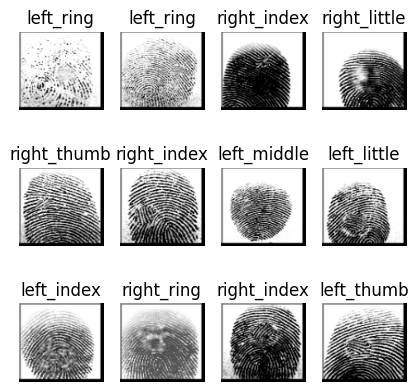

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Применяем CNN
Для классификации изображений традиционно будем использовать сверточную нейронную сеть

Для повышения производительности, используем предварительную загрузку и кэш данных

In [8]:
import tensorflow as tf
import numpy as np

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Для предотвращения переобучения, используем early stopping из `keras.callbacks`, который мониторит метрику validation loss, и предварительно завершает обучение если параметр на улучшался в течение 4 эпох. В качестве оптимизатора используем `adam`, а в качестве функции потерь - категориальную перекрестную энтропию

In [9]:
def evaluate_model(model, train_dataset, validation_dataset, epochs, verbose=False):
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

    model.compile(
        optimizer='adam',
        loss=tf.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )
    
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        callbacks=[early_stopping],
        batch_size=batch_size,
        epochs=epochs,
        verbose=int(verbose)
    )
    
    return history.history, model

В качестве модели используем немного модифицированную версию из [туториала](https://www.tensorflow.org/tutorials/images/cnn?hl=ru) tensorflow. Применяем также нормализацию изображений и в качестве последнего слоя - функцию активации softmax для получения вероятностного распределения. 

Количество эпох возьмём 30, но из-за "early stopping" обучение возможно закончится раньше

In [10]:
num_classes = len(class_names)
input_shape = (*image_size, 3)

model = keras.Sequential([
    keras.layers.Rescaling(1./255),
    
    keras.Input(shape=input_shape),
    
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(num_classes, activation="softmax"),
])

history = evaluate_model(
    model, 
    train_dataset, 
    validation_dataset, 
    epochs=30, 
    verbose=True
)[0]

print('Точность модели на тренировочных данных:', history['accuracy'][-1])

Epoch 1/30
225/225 [==============================] - 82s 362ms/step - loss: 1.5408 - accuracy: 0.4529 - val_loss: 1.2085 - val_accuracy: 0.5719
Epoch 2/30
225/225 [==============================] - 81s 359ms/step - loss: 1.0497 - accuracy: 0.6271 - val_loss: 0.9971 - val_accuracy: 0.6375
Epoch 3/30
225/225 [==============================] - 82s 362ms/step - loss: 0.7673 - accuracy: 0.7443 - val_loss: 0.7696 - val_accuracy: 0.7354
Epoch 4/30
225/225 [==============================] - 80s 354ms/step - loss: 0.4744 - accuracy: 0.8558 - val_loss: 0.5500 - val_accuracy: 0.8154
Epoch 5/30
225/225 [==============================] - 83s 370ms/step - loss: 0.2678 - accuracy: 0.9301 - val_loss: 0.4165 - val_accuracy: 0.8701
Epoch 6/30
225/225 [==============================] - 81s 359ms/step - loss: 0.1717 - accuracy: 0.9545 - val_loss: 0.3602 - val_accuracy: 0.8893
Epoch 7/30
225/225 [==============================] - 81s 359ms/step - loss: 0.1178 - accuracy: 0.9705 - val_loss: 0.3352 - val_ac

## Анализ модели на тестовых данных

In [14]:
test_data_dir = pathlib.Path('/kaggle/input/socofing/SOCOFing/Real')
test_dir = pathlib.Path(os.getcwd()) / 'test'

prepare_dataset(test_data_dir, test_dir)

Папка left_thumb уже существует
Папка left_index уже существует
Папка left_middle уже существует
Папка left_ring уже существует
Папка left_little уже существует
Папка right_thumb уже существует
Папка right_index уже существует
Папка right_middle уже существует
Папка right_ring уже существует
Папка right_little уже существует


In [16]:
import numpy as np


test_dataset = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    image_size=image_size,
    batch_size=batch_size,
    class_names=class_names
)

score = model.evaluate(test_dataset)
score

Found 6000 files belonging to 10 classes.
94/94 [==============================] - 9s 92ms/step - loss: 0.0454 - accuracy: 0.9918


[0.045373931527137756, 0.9918333292007446]

In [17]:
print('Точность модели на тестовых данных:', score[1])
print('Потери на тестовых данных:', score[0])

Точность модели на тестовых данных: 0.9918333292007446
Потери на тестовых данных: 0.045373931527137756


Для визуализации, возьмём несколько случайных изображений и посмотрим, какие результаты выдаст наша модель

1/1 [==============================] - 0s 23ms/step


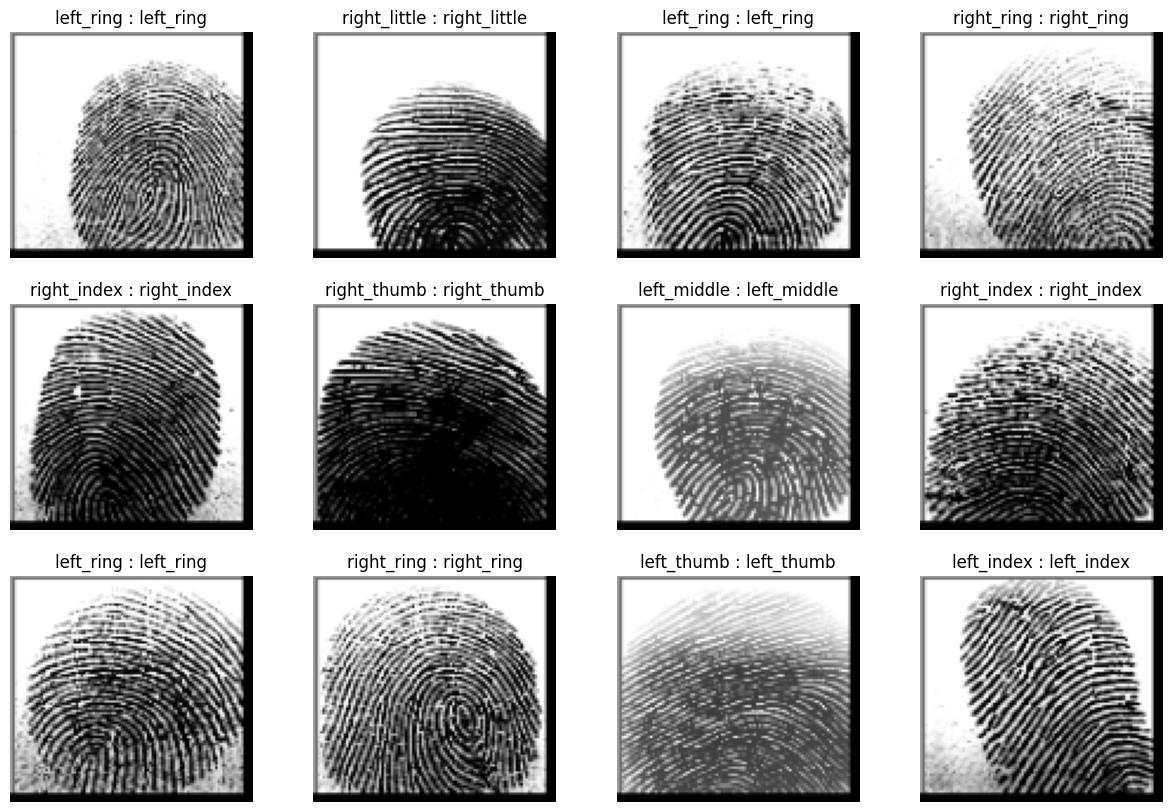

In [18]:
plt.figure(figsize=(15, 10))
predicted_labels = []
for images, labels in test_dataset.take(1):
    for i in range(12):
        corrected_image = tf.reshape(images[i], (-1, 96, 103, 3))
        predicted_label = class_names[np.argmax(model.predict(corrected_image))]
        predicted_labels.append(predicted_label)

        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f'{class_names[labels[i]]} : {predicted_label}')
        plt.axis("off")

Надпись слева - реальное определение пальца, а справа - результат работы модели. В данном случае, как можно заметить, модель верно предсказала все выбранные отпечатки пальцев